# EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from arch import arch_model

## Load dataset

In [3]:
df = pd.read_csv("../data/Tasla_Stock_Updated_V2.csv")
df.head(3)
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500
...,...,...,...,...,...,...
2269,2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700
2270,2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500
2271,2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600
2272,2024-01-12,220.080002,225.339996,217.149994,218.889999,122889000


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_20180\2110156169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
c:\Users\VICTUS\Documents\developer\self-learning\2025.1\stock-price-analysis\venv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


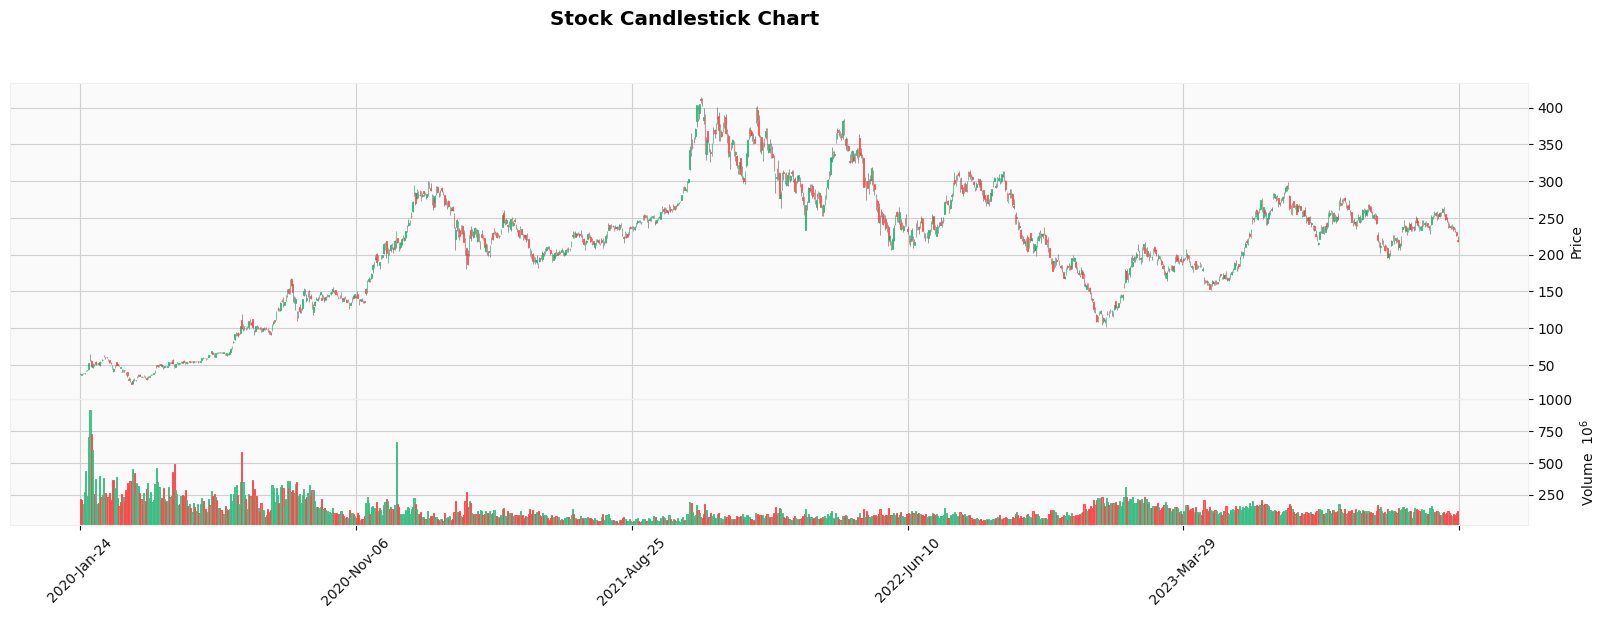

In [4]:
def visualize(df):
    """
    Visualize stock data with High, Low, Open, and Close prices over time.
    
    Parameters:
        df (pd.DataFrame): Must contain 'Date', 'High', 'Low', 'Open', 'Close' columns.
    """
    df['Date'] = pd.to_datetime(df['Date'])

    df = df.set_index('Date')

    mpf.plot(
        df,
        type='candle',
        style='yahoo',
        title='Stock Candlestick Chart',
        ylabel='Price',
        volume=True,              # show trading volume below chart
        # mav=(2,),                  # moving average (optional)
        figratio=(20, 6),
        figscale=1.1
    )

visualize(df[(2273-1000):2273])

In [5]:
returns = 100 * np.log(df['Close']).diff().dropna()

# Check the first few return values
print("--- Calculated Log Returns (first 5) ---")
print(returns.head())
print("\n")


# --- Step 2 & 3: Grid Search for the Best GARCH(p, q) Model ---

p_range = range(1, 4) # Test p from 1 to 3
q_range = range(1, 4) # Test q from 1 to 3

best_aic = np.inf
best_order = None
best_model_result = None

print("--- Running Grid Search for GARCH(p, q) ---")
for p in p_range:
    for q in q_range:
        try:
            # Create and fit the GARCH model
            # We use vol='Garch' for a standard GARCH model.
            model = arch_model(returns, p=p, q=q, vol='Garch', dist='Normal')
            model_fit = model.fit(disp='off') # disp='off' hides the fitting output

            # If the current model's AIC is better (lower), update our bests
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
                best_model_result = model_fit
            
            print(f'GARCH({p},{q}) | AIC: {model_fit.aic:.2f}')

        except Exception as e:
            # Some (p, q) combinations might not converge
            print(f'GARCH({p},{q}) failed to fit: {e}')
            continue

print("\n--- Grid Search Complete ---")
if best_order:
    print(f"Best Model Found: GARCH({best_order[0]},{best_order[1]}) with AIC: {best_aic:.2f}")
else:
    print("Could not find a suitable model.")

# --- Step 4: Analyze the Best Model ---
if best_model_result:
    print("\n--- Summary of the Best Model ---")
    print(best_model_result.summary())

--- Calculated Log Returns (first 5) ---
1   -4.295033
2    0.564826
3   -0.156315
4   -0.156553
5   -1.898063
Name: Close, dtype: float64


--- Running Grid Search for GARCH(p, q) ---
GARCH(1,1) | AIC: 11848.77
GARCH(1,2) | AIC: 11850.69
GARCH(1,3) | AIC: 11851.50
GARCH(2,1) | AIC: 11850.77
GARCH(2,2) | AIC: 11852.42
GARCH(2,3) | AIC: 11848.55
GARCH(3,1) | AIC: 11852.77
GARCH(3,2) | AIC: 11854.42
GARCH(3,3) | AIC: 11850.29

--- Grid Search Complete ---
Best Model Found: GARCH(2,3) with AIC: 11848.55

--- Summary of the Best Model ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5917.27
Distribution:                  Normal   AIC:                           11848.5
Method:            Maximum Likelihood   BIC:                    

In [8]:
if best_model_result:
    print("\n\n--- Bắt đầu sử dụng mô hình để dự báo ---")
    
    # Dự báo cho 5 ngày tiếp theo (horizon=5)
    # start=None có nghĩa là bắt đầu dự báo từ ngày cuối cùng trong bộ dữ liệu của bạn
    forecasts = best_model_result.forecast(horizon=5, start=None)
    
    # In kết quả dự báo ra màn hình
    # Kết quả sẽ bao gồm dự báo cho lợi nhuận trung bình (mean),
    # phương sai (variance), và độ biến động (volatility, là căn bậc 2 của phương sai)
    
    print("\n--- Dự báo Phương sai (Variance) cho 5 ngày tới ---")
    # .T để chuyển vị (transpose) cho dễ nhìn
    print(forecasts.variance.iloc[-1].T) 
    
    # Tính toán và in ra độ biến động (độ lệch chuẩn) dự báo
    # Đây là con số bạn sẽ dùng cho VaR
    predicted_volatility = np.sqrt(forecasts.variance.iloc[-1])
    
    print("\n--- Dự báo Độ biến động (Volatility) cho 5 ngày tới (%) ---")
    print(predicted_volatility)

else:
    print("Không có mô hình để thực hiện dự báo.")



--- Bắt đầu sử dụng mô hình để dự báo ---

--- Dự báo Phương sai (Variance) cho 5 ngày tới ---
h.1    7.348295
h.2    6.534935
h.3    7.512806
h.4    7.456918
h.5    6.952417
Name: 2273, dtype: float64

--- Dự báo Độ biến động (Volatility) cho 5 ngày tới (%) ---
h.1    2.710774
h.2    2.556352
h.3    2.740950
h.4    2.730736
h.5    2.636744
Name: 2273, dtype: float64


In [ ]:
import re
import pandas as pd

In [ ]:
# Dữ liệu SVG path bạn đã trích xuất
svg_path_data = "M 4.8333333333333 95.68 L 7.0570161025304 73.58 L 9.5189505969986 108.42 L 11.90146784971 94.9 L 14.363402344178 92.56 L 16.745919596889 89.7 L 19.207854091357 90.48 L 21.669788585825 97.75999999999999 L 24.052305838537 87.88 L 26.514240333005 94.38 L 28.896757585716 89.7 L 31.358692080184 68.12 L 33.820626574652 68.64 L 36.044309343849 53.040000000000006 L 38.506243838317 84.5 L 40.888761091029 100.36 L 43.350695585497 96.97999999999999 L 45.733212838208 98.28 L 48.195147332676 102.44 L 50.657081827144 98.02000000000001 L 53.039599079855 69.94 L 55.501533574324 76.7 L 57.884050827035 55.64 L 60.345985321503 52.519999999999996 L 62.807919815971 58.760000000000005 L 65.031602585168 49.66 L 67.493537079636 47.58 L 69.876054332347 17.680000000000007 L 72.337988826816 46.540000000000006 L 74.720506079527 75.66 L 77.182440573995 73.58 L 79.644375068463 79.82 L 82.026892321174 82.68 L 84.488826815642 94.64 L 86.871344068354 93.86 L 89.333278562822 90.22 L 91.79521305729 78 L 94.098313068244 68.38 L 96.560247562712 99.84 L 98.942764815423 102.7 L 101.40469930989 99.32 L 103.7872165626 110.75999999999999 L 106.24915105707 111.53999999999999 L 108.71108555154 87.62 L 111.09360280425 46.8 L 113.55553729872 81.9 L 115.93805455143 91.78 L 118.3999890459 96.97999999999999 L 120.86192354037 71.5 L 123.08560630956 69.68 L 125.54754080403 108.94 L 127.93005805674 103.47999999999999 L 130.39199255121 105.56 L 132.77450980392 102.7 L 135.23644429839 96.97999999999999 L 137.69837879286 82.42 L 140.08089604557 76.44 L 142.54283054004 91.26 L 144.92534779275 95.16 L 147.38728228722 90.74 L 149.84921678168 86.06 L 152.07289955088 89.7 L 154.53483404535 115.44 L 156.91735129806 101.92 L 159.37928579253 98.8 L 161.76180304524 68.12 L 164.22373753971 98.02000000000001 L 166.68567203418 98.28 L 169.06818928689 93.6 L 171.53012378136 101.14 L 173.91264103407 111.02000000000001 L 176.37457552854 110.24000000000001 L 178.836510023 109.2 L 181.0601927922 105.3 L 183.52212728667 100.1 L 185.90464453938 100.36 L 188.36657903385 99.84 L 190.74909628656 94.9 L 193.21103078103 100.62 L 195.6729652755 105.82 L 198.05548252821 109.46000000000001 L 200.51741702268 101.14 L 202.89993427539 102.18 L 205.36186876985 103.47999999999999 L 207.82380326432 104 L 210.12690327528 93.08 L 212.58883776974 89.18 L 214.97135502246 95.42 L 217.43328951692 89.96 L 219.81580676964 92.03999999999999 L 222.2777412641 100.62 L 224.73967575857 101.4 L 227.12219301128 89.96 L 229.58412750575 82.42 L 231.96664475846 91.52 L 234.42857925293 98.02000000000001 L 236.8905137474 92.03999999999999 L 239.1141965166 98.02000000000001 L 241.57613101106 98.53999999999999 L 243.95864826377 104 L 246.42058275824 117.78 L 248.80310001095 108.42 L 251.26503450542 101.14 L 253.72696899989 80.08 L 256.1094862526 88.66 L 258.57142074707 93.34 L 260.95393799978 100.62 L 263.41587249425 98.53999999999999 L 265.87780698872 90.74 L 268.10148975791 85.02 L 270.56342425238 111.02000000000001 L 272.94594150509 101.92 L 275.40787599956 89.7 L 277.79039325227 88.14 L 280.25232774674 106.34 L 282.71426224121 92.3 L 285.09677949392 88.66 L 287.55871398839 95.42 L 289.9412312411 111.53999999999999 L 292.40316573557 110.5 L 294.86510023004 101.4 L 297.08878299923 83.2 L 299.5507174937 109.46000000000001 L 301.93323474641 95.94 L 304.39516924088 91.26 L 306.77768649359 106.34 L 309.23962098806 99.32 L 311.70155548253 96.72 L 314.08407273524 95.68 L 316.54600722971 88.66 L 318.92852448242 79.04 L 321.39045897689 67.6 L 323.85239347136 72.02 L 326.15549348231 108.42 L 328.61742797678 122.72 L 330.99994522949 144.04 L 333.46187972396 104.78 L 335.84439697667 86.84 L 338.30633147114 93.6 L 340.7682659656 102.18 L 343.15078321832 100.88 L 345.61271771278 101.66 L 347.99523496549 104.25999999999999 L 350.45716945996 101.4 L 352.91910395443 102.44 L 355.14278672363 64.48 L 357.6047212181 111.02000000000001 L 359.98723847081 105.03999999999999 L 362.44917296528 99.84 L 364.83169021799 99.06 L 367.29362471245 87.88 L 369.75555920692 97.5 L 372.13807645963 120.12 L 374.6000109541 109.2 L 376.98252820681 95.68 L 379.44446270128 108.68 L 381.90639719575 99.06 L 384.13007996495 78 L 386.59201445942 85.8 L 388.97453171213 99.32 L 391.43646620659 94.12 L 393.81898345931 86.06 L 396.28091795377 93.6 L 398.74285244824 103.74000000000001 L 401.12536970095 93.6 L 403.58730419542 100.1 L 405.96982144813 93.86 L 408.4317559426 104.25999999999999 L 410.89369043707 90.48 L 413.11737320627 92.3 L 415.57930770073 109.97999999999999 L 417.96182495345 112.84 L 420.42375944791 103.74000000000001 L 422.80627670062 96.97999999999999 L 425.26821119509 92.3 L 427.73014568956 81.12 L 430.11266294227 75.92 L 432.57459743674 101.92 L 434.95711468945 97.5 L 437.41904918392 100.88 L 439.88098367839 95.94 L 442.18408368934 76.96 L 444.64601818381 109.97999999999999 L 447.02853543652 102.18 L 449.49046993099 102.7 L 451.8729871837 99.58 L 454.33492167817 91.52 L 456.79685617264 104 L 459.17937342535 96.46000000000001 L 461.64130791982 95.42 L 464.02382517253 100.62 L 466.485759667 96.46000000000001 L 468.94769416146 78.52 L 471.17137693066 95.16 L 473.63331142513 104.78 L 476.01582867784 102.18 L 478.47776317231 99.84 L 480.86028042502 91.52 L 483.32221491949 101.14 L 485.78414941396 102.7 L 488.16666666667 93.08"

# Sử dụng regular expression để tìm tất cả các cặp số trong chuỗi
# \d+\.?\d* tìm các số nguyên hoặc số thực
# (\s+) tìm một hoặc nhiều khoảng trắng ở giữa
coordinates = re.findall(r'(\d+\.?\d*)\s+(\d+\.?\d*)', svg_path_data)

# Chuyển đổi các chuỗi số thành số thực (float) và lưu vào DataFrame
df_coords = pd.DataFrame(coordinates, columns=['x', 'y'])
df_coords['x'] = df_coords['x'].astype(float)
df_coords['y'] = df_coords['y'].astype(float)

print("--- Dữ liệu tọa độ đã được trích xuất vào DataFrame ---")
print(df_coords.head())